## Problem Definition

In [1]:
import random
import numpy as np
import gym
from gym import spaces
import torch

from typing import List, Callable, Optional

RANDOM_SEED = 42
SIGMA_NOISE = 0.05
torch.manual_seed(RANDOM_SEED)

from constants import DTYPE, FIG_HEIGHT, DPI, LABEL_FONT_SIZE

class CircleRotation(gym.Env):

    def __init__(self,
                 s_goals: List[np.array],
                 seed: int,
                 encoder: Optional[Callable[[np.array], np.array]] = None,
                 decoder: Optional[Callable[[np.array], np.array]] = None,
                 sigma_noise=SIGMA_NOISE):
        
        """Circle navigation environment."""


        self.seed(seed)

        if encoder is not None:
            assert decoder is not None, "Provide a decoder if you provide an encoder."
        if decoder is not None:
            assert encoder is not None, "Provide an encoder if you provide a decoder."

        # State and action spaces
        self.sigma_noise = sigma_noise
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Box(low=-0.2, high=0.2, shape=(2,), dtype=np.float32)

        # Set encoder and decoder. Set to identity map if none are provided to shorten code.
        self.encoder = encoder if encoder is not None else lambda p: p
        self.decoder = decoder if decoder is not None else lambda p: p

        # Define goal state
        self.goal_states = s_goals
        self.goal_state = random.choice(self.goal_states).copy()

        # Define initial state
        self._point = np.array([0.0, 0.0], dtype=np.float32)
        self._point = self.encoder(self._point)
        dist = np.linalg.norm(self.decoder(self._point) - self.goal_state)
        self.s = np.concatenate([self._point, (dist,)])

        self.episode_length = 100
        self.step_count = 0


    def reset(self):

        '''
        Reset the system to its initial state. Samples a new task.
        '''
        self.step_count = 0

        #Reset state
        self._point = np.zeros_like(self.goal_state)
        self._point = self.encoder(self._point)
        self.goal_state = random.choice(self.goal_states).copy()
        dist = np.linalg.norm(self.decoder(self._point) - self.goal_state)
        
        return np.concatenate([self._point, (dist, )])
    

    def step(self, u):

        '''
        Step the system forward by one time step from state s with control input u. Returns the next state, the cost and whether the episode is done.
        '''

        # Compute reward.
        dist = np.linalg.norm(self.decoder(self._point) - self.goal_state)
        reward = -dist
        self.step_count += 1

        # Check if episode is done.
        if self.step_count == self.episode_length-1 or np.allclose(self.decoder(self._point), self.goal_state, atol=0.2):
            done = True
            self.step_count = 0
            reward += 5
        else:
            done = False

        # Compute next state.
        self._point = self.decoder(self._point) + u
        self._point = self.encoder(self._point)

        self._point += np.random.normal(loc=0, scale=self.sigma_noise, size=2) if self.sigma_noise > 0 else 0
        self.s = np.concatenate([self._point, (dist,)])

        return self.s, reward, done, {}
    

    def seed(self, seed=None):
        np.random.seed(seed)
        return [seed]

In [2]:
def generate_circle_points(angles):
    """Generates 2-D coordinates on a circle, given by an array of angles in radians."""
    x = RADIUS*np.cos(angles)
    y = RADIUS*np.sin(angles)
    points = np.stack((x, y), axis=1)
    return points

# Example
N_TOTAL_TASKS = 9
RADIUS=2
IDXS_TRAIN_TASKS = [0] #only use one task as geometry is global
CIRCLE_ANGLES = np.linspace(0, 2 * np.pi, N_TOTAL_TASKS, endpoint=False)
IDX_TEST_TASKS = set(range(N_TOTAL_TASKS)) - set(IDXS_TRAIN_TASKS)

goal_positions_all = generate_circle_points(CIRCLE_ANGLES)
goal_positions_train = [goal_positions_all[idx] for idx in IDXS_TRAIN_TASKS]
goal_positions_test = [goal_positions_all[idx] for idx in IDX_TEST_TASKS]

print("Goal Positions Train:")
for pos in goal_positions_train:
    print(pos.round(2))

print("\nGoal Positions Test:")
for pos in goal_positions_test:
    print(pos.round(2))

Goal Positions Train:
[2. 0.]

Goal Positions Test:
[1.53 1.29]
[0.35 1.97]
[-1.    1.73]
[-1.88  0.68]
[-1.88 -0.68]
[-1.   -1.73]
[ 0.35 -1.97]
[ 1.53 -1.29]


In [9]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import os

# Training setup
N_ENVS=1 #does not learn for more envs as environment too simple!
N_STEPS=30_000

# Make the environment
env = CircleRotation(s_goals=goal_positions_train, seed=RANDOM_SEED)

# Optionally wrap in a vectorized env (recommended for SB3)
vec_env = make_vec_env(lambda: env, n_envs=N_ENVS, seed=RANDOM_SEED)

# Create the model
model = SAC("MlpPolicy", vec_env, verbose=1, seed=RANDOM_SEED)

# Train the model
model.learn(total_timesteps=N_STEPS)

## Roll-Out Policy on New Tasks

In [4]:
import matplotlib.pyplot as plt

def sample_traj_of_env(environment, trained_model):
    n_steps = 100
    obs = environment.reset()
    trajectory = []
    rewards = []
    actions = []
    trajectory.append(obs.copy())

    for _ in range(n_steps):
        action, _ = trained_model.predict(obs, deterministic=True)
        obs, reward, done, _ = environment.step(action)

        actions.append(action)
        trajectory.append(obs.copy())
        rewards.append(reward)

        if done:
            break

    trajectory = np.array(trajectory)
    rewards = np.array(rewards)
    actions = np.array(actions)

    return trajectory, actions, rewards

trajs_all_tasks_train = []
trajs_all_tasks_test = []
actions_all_tasks_train = []
actions_all_tasks_test = []
RANDOM_SEEDS_EVALUATION = np.random.choice(np.arange(10_000), size=N_TOTAL_TASKS, replace=False)

for idx_goal_position, goal_position in enumerate(goal_positions_all):
    test_env = CircleRotation(s_goals=[goal_position], seed=RANDOM_SEEDS_EVALUATION[idx_goal_position])
    traj, actions, rewards = sample_traj_of_env(test_env, model)
    if any(np.array_equal(goal_position, s_inits) for s_inits in goal_positions_train):
        trajs_all_tasks_train.append(traj)
        actions_all_tasks_train.append(actions)
        rewards_train=rewards
    else:
        trajs_all_tasks_test.append(traj)
        actions_all_tasks_test.append(actions)        
    del test_env

In [5]:
import matplotlib.pyplot as plt

def plot_rollouts_on_circle(train_trajectories,
                             test_trajectories,
                             train_goal_locations,
                             test_goal_locations,
                             idx_label_test=3,
                             legend: bool=False,
                             savepath: str=None):
    """Plots trajectories from the different tasks on the circle."""

    # 1. Set fixed figure size (square)
    fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

    use_label_train: bool = True
    label=None
    cmap = plt.get_cmap('hsv')

    num_trajs = len(test_trajectories)
    
    # Train distribution
    circle = plt.Circle((0, 0), RADIUS, color='black', fill=False, linestyle='--', linewidth=2, label=r'$p(\mathcal{T})$', zorder=3, alpha=0.3)
    ax.add_artist(circle)

    for idx_traj, test_traj in enumerate(test_trajectories):
        color = cmap(0.5 + 0.5 * idx_traj / max(1, num_trajs - 1))
        if idx_traj == idx_label_test:
            label = "Test"
            ax.plot(test_traj[:-1,0], test_traj[:-1,1], marker="x", color=color, alpha=1, label=label)
        else:
            ax.plot(test_traj[:-1,0], test_traj[:-1,1], marker="x", color=color, alpha=1, label=None)
        ax.scatter(test_goal_locations[idx_traj][0], test_goal_locations[idx_traj][1], color=color, marker="X", s=500)

    for idx_traj, train_traj in enumerate(train_trajectories):
        if use_label_train:
            label="Train"
            use_label_train=False
            ax.plot(train_traj[:-1,0], train_traj[:-1,1], marker="x", color="black", alpha=1, label=label)
        else:
            ax.plot(train_traj[:-1,0], train_traj[:-1,1], marker="x", color="black", alpha=1, label=None)
        ax.scatter(train_goal_locations[idx_traj][0], train_goal_locations[idx_traj][1], color="black", marker="X", s=500)


    ax.set_xlim(-RADIUS-0.5, RADIUS+0.5)
    ax.set_ylim(-RADIUS-0.5, RADIUS+0.5)
    ax.set_aspect('equal')
    ax.axis('off')

    if legend:
        ax.legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5, 0.05), fontsize=LABEL_FONT_SIZE)

    # 2. Save figure
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', pad_inches=0.05, dpi=DPI)

    plt.show()

    plt.close(fig)


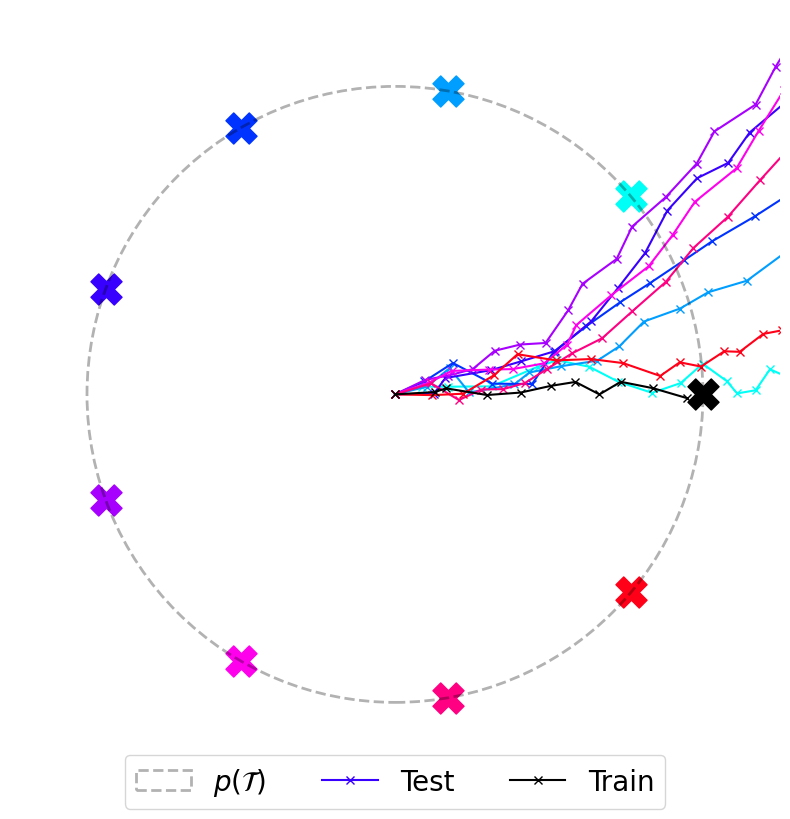

In [6]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train,
                        test_trajectories=trajs_all_tasks_test,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_positions_test,
                        legend=True,
                        # savepath=None
                        savepath="circle_nav_vanilla_meta_rl"
                        )

## Equivariant Policy (with ground-truth task encodings)

- No Encoder for symmetry yet

In [7]:
LG = lambda theta : np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0], [0, 0, 1]]) #Runs counter-clockwise! Is inverse as shown in master thesis

def sample_traj_of_hereditary_env(task, base_policy, Lg):
    """Rolls out a base policy in a new task by transforming the state and action spaces, not the reward and transition function."""

    trajectory = []
    rewards = []
    actions = []

    n_steps = 100
    obs_tilde = task.reset()
    trajectory.append(obs_tilde.copy())
    obs_base = Lg @ obs_tilde

    for _ in range(n_steps):
        action_base, _ = base_policy.predict(obs_base, deterministic=True)
        obs_tilde, reward, done, _ = task.step(action_base)

        obs_base = Lg @ obs_tilde

        actions.append(action_base)
        trajectory.append(obs_tilde.copy())
        rewards.append(reward)

        if done:
            break  # end the rollout

    return np.array(trajectory)


trajs_all_tasks_train_equ = []
trajs_all_tasks_test_equ = []
actions_all_tasks_train_equ = []
actions_all_tasks_test_equ = []
lgs_ground_truth = []

# Create environment. Now, all tasks are in same environment.
hereditary_env = CircleRotation(s_goals=goal_positions_train, seed=RANDOM_SEED, encoder=None, decoder=None)
hereditary_env.reset()

for task_idx, goal_position in enumerate(goal_positions_all):
    g_action = CIRCLE_ANGLES[task_idx]
    Lg_test_task = LG(g_action)
    lgs_ground_truth.append(Lg_test_task)

    traj_equ = sample_traj_of_hereditary_env(task=hereditary_env, base_policy=model, Lg=Lg_test_task)

    if any(np.array_equal(goal_position, s_goal) for s_goal in goal_positions_train):
        trajs_all_tasks_train_equ.append(traj_equ)
    else:
        trajs_all_tasks_test_equ.append(traj_equ)


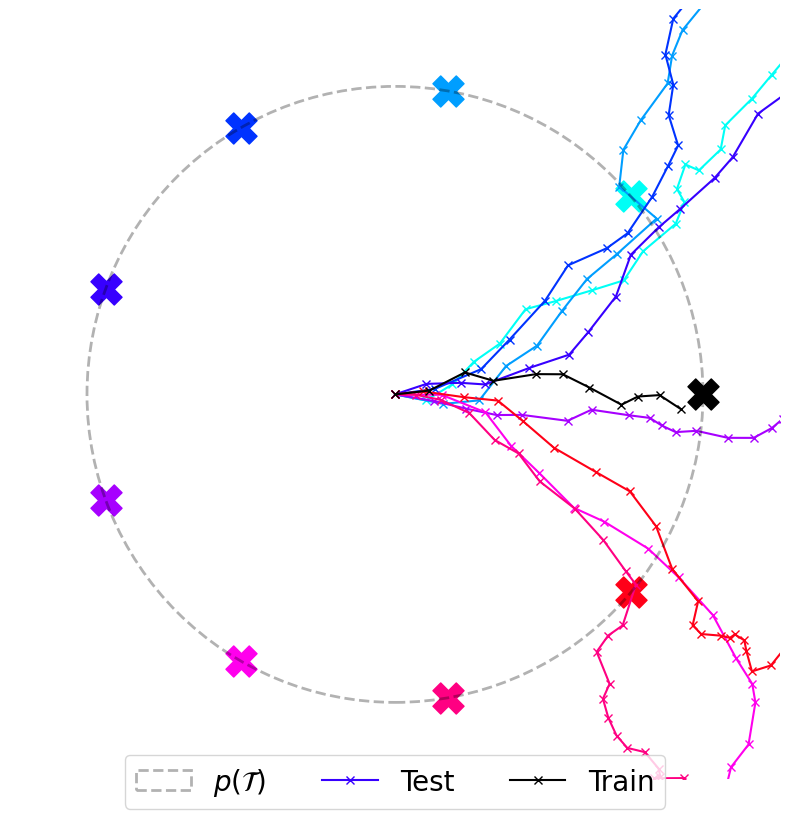

In [8]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train_equ,
                        test_trajectories=trajs_all_tasks_test_equ,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_positions_test,
                        legend=True,
                        # savepath=None
                        savepath="circle_nav_hereditary_meta_rl"
                        )

## Train Symmetric Policy

In [10]:
ENCODER = lambda p : p - np.array([RADIUS,0], dtype=np.float32)
DECODER = lambda p : p + np.array([RADIUS,0], dtype=np.float32)


# Make the environment
encoded_env = CircleRotation(s_goals=goal_positions_train, 
                     encoder=ENCODER,
                     decoder=DECODER,
                     seed=RANDOM_SEED)

vec_encoded_env = make_vec_env(lambda: encoded_env, n_envs=N_ENVS, seed=RANDOM_SEED)

encoded_model = SAC("MlpPolicy", vec_encoded_env, verbose=1, seed=RANDOM_SEED)
del vec_encoded_env

encoded_model.learn(total_timesteps=N_STEPS)

/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -209     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 84       |
|    time_elapsed    | 4        |
|    total_timesteps | 396      |
| train/             |          |
|    actor_loss      | 1.12     |
|    critic_loss     | 0.305    |
|    ent_coef        | 0.916    |
|    ent_coef_loss   | -0.297   |
|    learning_rate   | 0.0003   |
|    n_updates       | 295      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 91.8     |
|    ep_rew_mean     | -173     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 72       |
|    time_elapsed    | 10       |
|    total_timesteps | 734      |
| train/             |          |
|    actor_loss      | 1.79     |
|    critic_loss     | 0.291   

In [11]:
encoded_trajs_all_tasks_train = []
encoded_trajs_all_tasks_test = []

for idx_goal_position, goal_position in enumerate(goal_positions_all):

    # Create environments, should be no change to vanilla Meta-RL.
    test_env = CircleRotation(s_goals=[goal_position], encoder=ENCODER, decoder=DECODER, seed=RANDOM_SEED)

    # Sample trajectory.
    traj, _, _ = sample_traj_of_env(test_env, encoded_model)
    if any(np.array_equal(goal_position, s_inits) for s_inits in goal_positions_train):
        encoded_trajs_all_tasks_train.append(traj)
    else:
        encoded_trajs_all_tasks_test.append(traj)
    del test_env

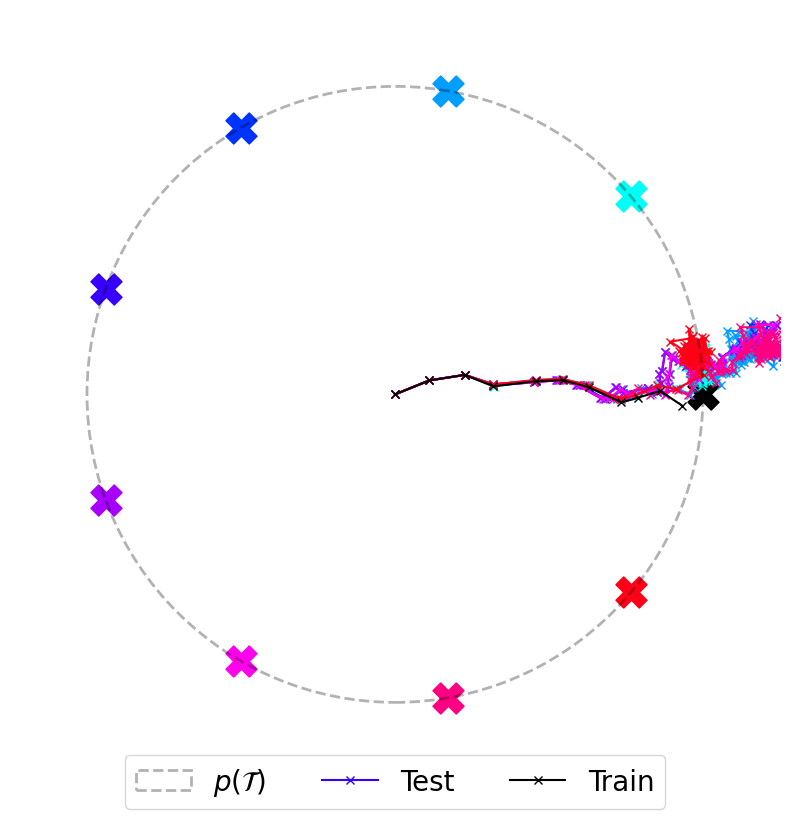

In [12]:
decoded_trajs_all_tasks_train = [DECODER(encoded_traj[:,:2]) for encoded_traj in encoded_trajs_all_tasks_train]
decoded_trajs_all_tasks_test = [DECODER(encoded_traj[:,:2]) for encoded_traj in encoded_trajs_all_tasks_test]

plot_rollouts_on_circle(train_trajectories=decoded_trajs_all_tasks_train,
                        test_trajectories=decoded_trajs_all_tasks_test,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_positions_test,
                        legend=True,
                        # savepath=None
                        # savepath="circle_nav_vanilla_meta_rl"
                        )

In [21]:
KG = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def sample_traj_of_symmetric_env(task, policy, Kg):
    """Rolls out a base policy in a new task via symmetry by transforming the state and action spaces, not the reward and transition function."""

    trajectory = []

    n_steps = 100
    obs = task.reset()
    trajectory.append(obs.copy())

    for _ in range(n_steps):
        action_base, _ = policy.predict(obs, deterministic=True)
        action_tilde = Kg @ action_base
        obs, _, done, _ = task.step(action_tilde)

        trajectory.append(obs.copy())

        if done:
            break

    return np.array(trajectory)


trajs_all_tasks_train_sym = []
trajs_all_tasks_test_sym = []
kgs_ground_truth = []

# Create environment, all tasks are now in same environment.
test_env = CircleRotation(s_goals=goal_positions_train, seed=RANDOM_SEED, encoder=ENCODER, decoder=DECODER)
test_env.reset()


for task_idx, goal_position in enumerate(goal_positions_all):
    g_action=CIRCLE_ANGLES[task_idx]
    Kg_task = KG(g_action)
    kgs_ground_truth.append(Kg_task)

    # traj_equ = sample_traj_of_symmetric_env(task=test_env, base_policy=model, Kg=Kg_test_task)
    traj_equ = sample_traj_of_symmetric_env(task=test_env, policy=encoded_model, Kg=Kg_task)
    # traj_base = sample_traj_of_env(environment=test_env, trained_model=)
    
    if any(np.array_equal(goal_position, s_goal) for s_goal in goal_positions_train):
        print(goal_position)
        print(goal_positions_train)
        print(g_action)
        print(Kg_task)
        trajs_all_tasks_train_sym.append(traj_equ)
    else:
        trajs_all_tasks_test_sym.append(traj_equ)


[2. 0.]
[array([2., 0.])]
0.0
[[ 1. -0.]
 [ 0.  1.]]


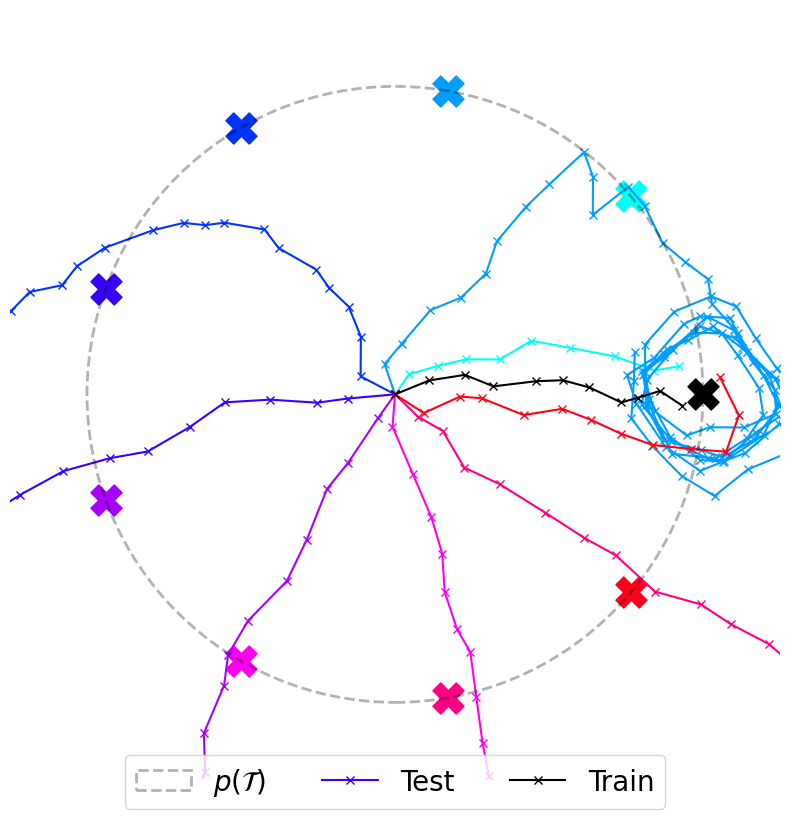

In [22]:
decoded_sym_trajs_all_tasks_train = [DECODER(encoded_traj[:,:2]) for encoded_traj in trajs_all_tasks_train_sym]
decoded_sym_trajs_all_tasks_test = [DECODER(encoded_traj[:,:2]) for encoded_traj in trajs_all_tasks_test_sym]

plot_rollouts_on_circle(train_trajectories=decoded_sym_trajs_all_tasks_train,
                        test_trajectories=decoded_sym_trajs_all_tasks_test,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_positions_test,
                        legend=True,
                        # savepath=None
                        # savepath="circle_nav_sym_meta_rl"
                        )